In [1]:
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("./ml-latest-small/ratings.csv")
# df = pd.read_csv("/home/tianyou/ml-latest/ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
n_users = df.userId.unique().shape[0]
n_items = df.movieId.unique().shape[0]
n_users, n_items

(610, 9724)

In [4]:
movie_movieId = df.movieId.unique().tolist()
movie_movieId.sort()
d = dict()
for i in range(0, len(movie_movieId)):
    d[movie_movieId[i]] = i

In [5]:
def user_item_matrix(data):
    ratings = np.zeros((n_users, n_items))
    for row in data.itertuples():
        ratings[row[1]-1, d[row[2]]] = row[3]
    return ratings

In [6]:
train_set, test_set = train_test_split(df)

In [7]:
ratings = user_item_matrix(df)
train = user_item_matrix(train_set)
test = user_item_matrix(test_set)
train

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [8]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 1.70%


In [21]:
def normalize(data, kind='user'):
    data2 = data.copy()
    data2[data2 == 0] = np.nan
    # print(np.nanmean(data[0]))
    if kind == 'user':
        for i in range(0, data2.shape[0]):
            data2[i] = data2[i] - np.nanmean(data2[i])
            # data[i][data[i] == 0] = np.nanmean(data[i])
            
    if kind == 'item':
        for j in range(0, data.shape[1]):
            data2.T[j] = data2.T[j] - np.nanmean(data2.T[j])

    data[np.isnan(data2)] = 0
    return (data2)

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    user_norm_matrix = normalize(train, kind = 'user')
    item_norm_matrix = normalize(train, kind = 'item')

In [27]:
def similarity(ratings, kind='user', epsilon=1e-12):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [30]:
user_norm_sim_matrix = similarity(user_norm_matrix, kind = 'user')
item_norm_sim_matrix = similarity(item_norm_matrix, kind = 'item')
user_sim_matrix = similarity(train, kind = 'user')
item_sim_matrix = similarity(train, kind = 'item')
print(user_sim_matrix)
print(user_norm_sim_matrix)

[[1.00000000e+00 1.62018917e-02 1.06449929e-02 ... 2.51880403e-01
  8.89341981e-02 1.27796661e-01]
 [1.62018917e-02 1.00000000e+00 2.93772236e-15 ... 4.76525637e-02
  3.25522570e-02 8.73564116e-02]
 [1.06449929e-02 2.93772236e-15 1.00000000e+00 ... 2.44899123e-02
  3.39484700e-15 1.96090942e-02]
 ...
 [2.51880403e-01 4.76525637e-02 2.44899123e-02 ... 1.00000000e+00
  1.09444591e-01 2.24551417e-01]
 [8.89341981e-02 3.25522570e-02 3.39484700e-15 ... 1.09444591e-01
  1.00000000e+00 5.13623567e-02]
 [1.27796661e-01 8.73564116e-02 1.96090942e-02 ... 2.24551417e-01
  5.13623567e-02 1.00000000e+00]]
[[ 1.00000000e+00 -3.14447765e-04 -8.23113021e-03 ...  2.65088540e-02
   7.58379364e-02 -3.64483848e-02]
 [-3.14447765e-04  1.00000000e+00  2.79773272e-14 ... -7.57344625e-03
   1.65149217e-02  6.13750399e-02]
 [-8.23113021e-03  2.79773272e-14  1.00000000e+00 ... -8.99614065e-03
   4.53811335e-14  1.44108876e-02]
 ...
 [ 2.65088540e-02 -7.57344625e-03 -8.99614065e-03 ...  1.00000000e+00
   4.31644

In [31]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        result = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        # result[result < 0.5] = 1
        return result
    elif kind == 'item':
        result = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        # result[result < 0.5] = 1
        return result

In [32]:
user_norm_prediction = predict_fast_simple(train, user_norm_sim_matrix, kind = 'user')
item_norm_prediction = predict_fast_simple(train, item_norm_sim_matrix, kind = 'item')
user_prediction = predict_fast_simple(train, user_sim_matrix, kind = 'user')
item_prediction = predict_fast_simple(train, item_sim_matrix, kind = 'item')
print(user_prediction)
print(item_prediction)

[[1.42085807e+00 6.60984598e-01 3.61082646e-01 ... 2.33749817e-17
  0.00000000e+00 3.04833709e-03]
 [1.12711811e+00 5.05598183e-01 9.44425150e-02 ... 1.27488312e-02
  0.00000000e+00 1.76286261e-02]
 [1.23721847e+00 6.32616760e-01 2.96095824e-01 ... 9.63451704e-16
  0.00000000e+00 1.05141400e-15]
 ...
 [1.39438008e+00 7.54045016e-01 3.08938548e-01 ... 9.85206888e-04
  0.00000000e+00 8.71170446e-03]
 [1.40704092e+00 6.59251609e-01 2.75399569e-01 ... 9.05772246e-17
  0.00000000e+00 5.14003598e-03]
 [1.38121090e+00 6.81781927e-01 2.12144760e-01 ... 5.27606686e-03
  0.00000000e+00 1.12487270e-02]]
[[2.50825061e-01 2.15450321e-01 3.18590517e-01 ... 2.36836297e-13
  4.66794425e-08 1.41680594e-01]
 [2.59438708e-02 2.32028258e-02 1.24269464e-02 ... 4.48325306e-02
  6.10613175e-09 1.89652250e-01]
 [8.45909956e-03 8.37636223e-03 1.06310630e-02 ... 4.69949682e-14
  9.26251147e-09 1.17210742e-13]
 ...
 [5.26696906e-01 5.21186627e-01 5.69746113e-01 ... 4.73446115e-02
  1.33169194e-07 1.10421407e+00]

In [33]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(actual, pred)

In [34]:
print ('User_norm-based CF MSE: ' + str(get_mse(user_norm_prediction, test)))
print ('Item_norm-based CF MSE: ' + str(get_mse(item_norm_prediction, test)))
print ('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User_norm-based CF MSE: 13.471213720416953
Item_norm-based CF MSE: 13.206030342254401
User-based CF MSE: 10.61668438671962
Item-based CF MSE: 11.493179853447685


In [35]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [38]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    pred = predict_topk(train, user_sim_matrix, kind='user', k=15)
    print ('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

    pred = predict_topk(train, item_sim_matrix, kind='item', k=15)
    print ('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 8.839542603533665
Top-k Item-based CF MSE: 9.564088460889241


In [43]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        user_pred = predict_topk(train, user_sim_matrix, kind='user', k=k)
        item_pred = predict_topk(train, item_sim_matrix, kind='item', k=k)

    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

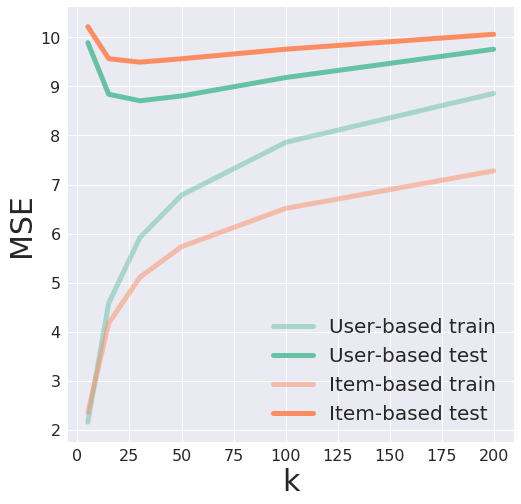

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);